In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from scipy import stats

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

inspector = inspect(engine)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
measurement_columns = inspector.get_columns('measurement')
for column in measurement_columns:
    print(column['name'], column['type'])

station_columns = inspector.get_columns('station')
for column in station_columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

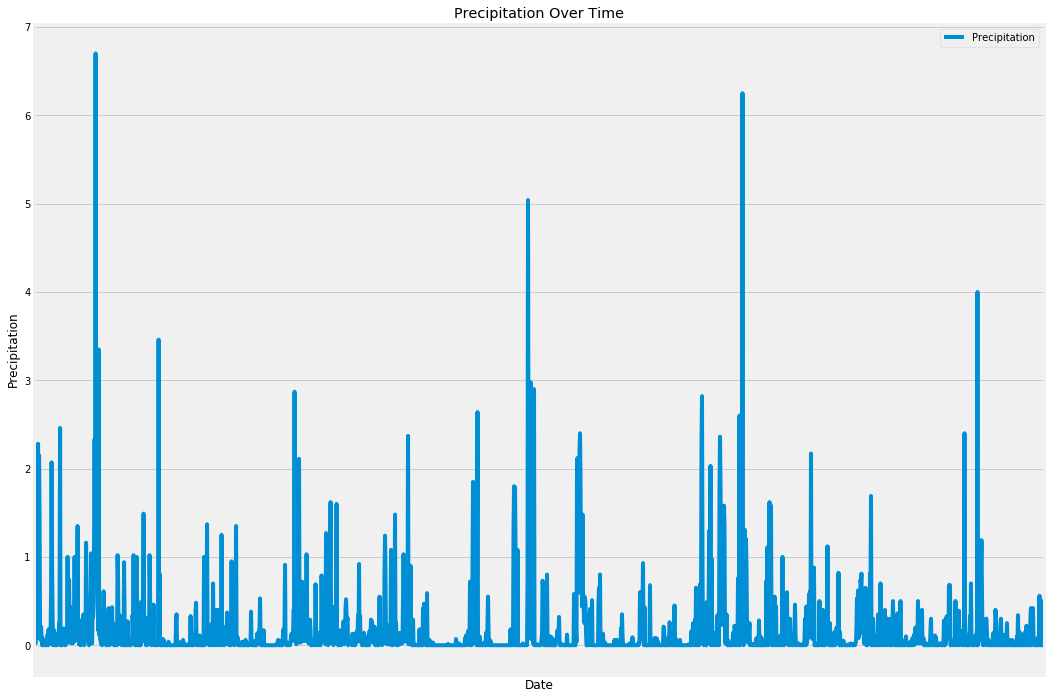

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Perform a query to retrieve the data and precipitation scores
last_year_data = []
last_year = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= '2016-08-23').order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_prcp = pd.DataFrame(last_year, columns = ['Date', 'Precipitation'])
last_year_prcp.set_index('Date', inplace=True)
last_year_prcp.dropna(how='all', inplace=True)

# Sort the dataframe by date
last_year_prcp = last_year_prcp.sort_values('Date', ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
ticks = []
last_year_prcp.plot(kind='line', figsize=(15,10))
plt.ylabel('Precipitation')
plt.xlabel('Date')
plt.title('Precipitation Over Time')
plt.tight_layout()
plt.xticks(ticks)
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_year_prcp.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(func.count(Station.id)).all()
num_stations

[(9)]

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_df = pd.read_sql('Select station, count(station) from measurement group by station', engine)
station_df.sort_values('count(station)', ascending = False)

,station,count(station)
6,USC00519281,2772
7,USC00519397,2724
1,USC00513117,2709
8,USC00519523,2669
3,USC00516128,2612
2,USC00514830,2202
0,USC00511918,1979
4,USC00517948,1372
5,USC00518838,511


In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
station_id = 'USC00519281'
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == station_id).all()


[(54.0, 85.0, 71.66378066378067)]

Text(0.5, 1.0, 'Temperature vs. Month')

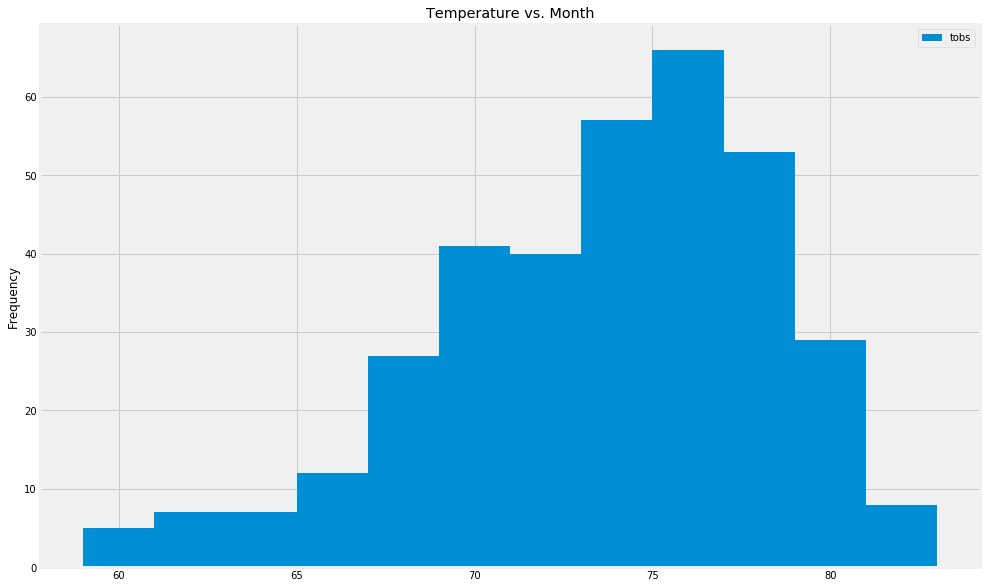

In [16]:
# Choose the station with the highest number of temperature observations.
station_df = pd.read_sql("Select station, count(tobs) from measurement group by station", engine)
station_df.sort_values('count(tobs)', ascending=False)

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
df = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == station_id).\
    filter(Measurement.date >= '2016-08-23')

df = pd.DataFrame(df)
df.plot(kind='hist', bins=12, figsize=(15,10))
plt.title('Temperature vs. Month')

## Temperature Analysis I

In [17]:
csv_data = pd.read_csv('Resources/hawaii_measurements.csv')
temp_comp1 = pd.DataFrame(csv_data)
date_list= []
dates = session.query(Measurement.date).all()
dates = list(np.ravel(dates))
# Stip off the year and save a list of %m-%d strings
for date in dates:
    day_num = dt.datetime.strptime(date, "%Y-%m-%d")
    day_reg = dt.datetime.strftime(day_num, "%m")
    date_list.append(day_reg)

temp_comp1['Dates (Month)'] = date_list
june = temp_comp1.loc[temp_comp1['Dates (Month)'] == '06']
dec = temp_comp1.loc[temp_comp1['Dates (Month)'] == '12']

print(f"June Average Temperature: {june['tobs'].mean()}")
print(f"December Average Temperature: {dec['tobs'].mean()}")
stats.ttest_ind(june['tobs'], dec['tobs'], equal_var=False)

June Average Temperature: 74.94411764705882
December Average Temperature: 71.04152933421226


Ttest_indResult(statistic=31.355036920962423, pvalue=4.193529835915755e-187)

## Temperature Analysis II

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tmin, tavg, tmax = calc_temps('2015-02-16', '2015-03-05')[0]

Text(0, 0.5, 'Average Temperature')

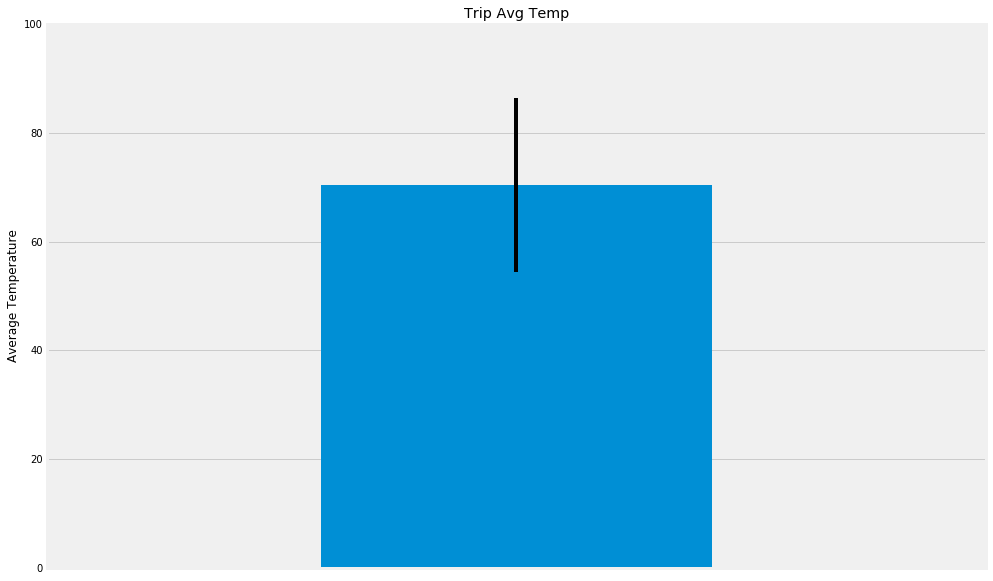

In [68]:
# Plot the results from your previous query as a bar chart.
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

temps = calc_temps('2016-02-16', '2016-03-05')
temps_list = temps[0]

yerr = tmax-tmin
x_position = 1

temps_df = pd.DataFrame(temps_list)
temps_df = temps_df.rename(columns={0: 'Temperature'})
temps_df = temps_df.rename(index={0: 'MinTemp', 1: 'AvgTemp', 2: 'MaxTemp'})
temps_df.index.name = 'Type'
plt.figure(figsize=(15,10))
plt.bar(x_position, tavg, yerr=yerr, align='center')
plt.margins(0.7, 0.7)
plt.ylim(0, 100)
plt.xticks([])
plt.title('Trip Avg Temp')
plt.ylabel('Average Temperature')


In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
total_rainfall = session.query(Measurement.station, func.sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude, Station.elevation).\
    filter(Measurement.station == Station.station).filter(Measurement.date >= '2016-02-16').filter(Measurement.date <= '2016-03-05').\
    group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

for rainfall in total_rainfall:
    print(rainfall)

('USC00513117', 0.9500000000000001, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
('USC00519523', 0.8500000000000001, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
('USC00514830', 0.8200000000000001, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
('USC00519281', 0.6499999999999999, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
('USC00519397', 0.29, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
('USC00516128', 0.75, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)
('USC00517948', None, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)


## Optional Challenge Assignment

In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
start_date = '2016-02-16'
end_date = '2016-03-05'

# Use the start and end date to create a range of dates
date_list= []
trip_dates = session.query(Measurement.date).filter(Measurement.date >= '2016-02-16').filter(Measurement.date <= '2016-03-05').group_by(Measurement.date).all()
trip_dates = list(np.ravel(trip_dates))
# Stip off the year and save a list of %m-%d strings
for date in trip_dates:
    day_num = dt.datetime.strptime(date, "%Y-%m-%d")
    day_reg = dt.datetime.strftime(day_num, "%m-%d")
    date_list.append(day_reg)

# Loop through the list of %m-%d strings and calculate the normals for each date
for date in date_list:
    normals.append(daily_normals(date))

normal_list = []
for normal in normals:
    normal_list.append(normal[0])

In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normal_list, columns=['min temp', 'avg temp', 'max temp'], index=trip_dates)
df

,min temp,avg temp,max temp
2016-02-16,59.0,70.482143,76.0
2016-02-17,62.0,70.472727,77.0
2016-02-18,63.0,70.796296,77.0
2016-02-19,60.0,69.339623,77.0
2016-02-20,63.0,70.140351,76.0
2016-02-21,63.0,69.796296,76.0
2016-02-22,60.0,70.157895,83.0
2016-02-23,62.0,70.355932,81.0
2016-02-24,61.0,68.566667,76.0
2016-02-25,61.0,68.596491,76.0


Text(0.5, 1.0, 'Daily Normals for Feb. 16, 2016 through Mar. 5, 2016')

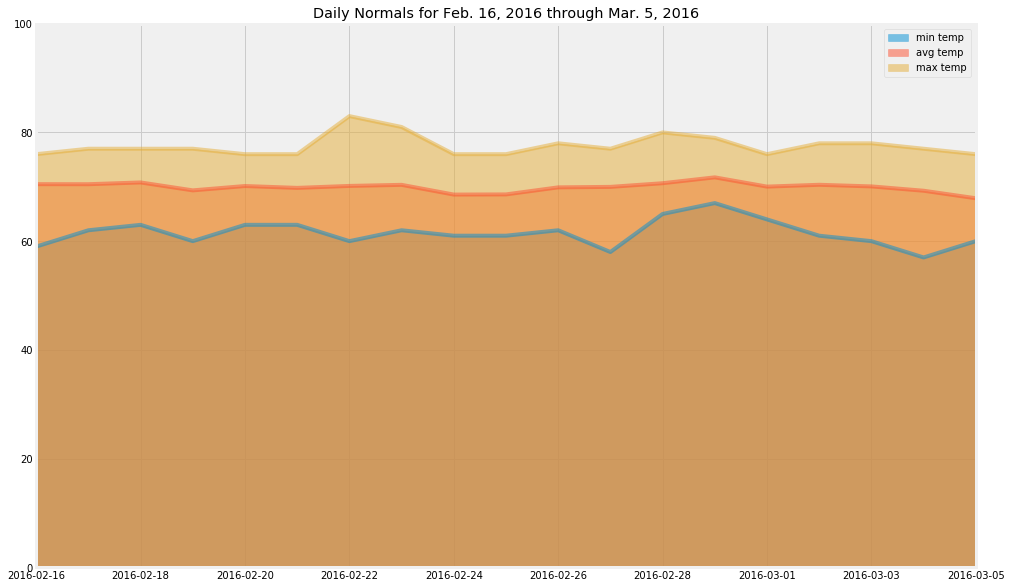

In [27]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot(kind='area', stacked=False, figsize = (15,10))
plt.ylim(0, 100)
plt.title('Daily Normals for Feb. 16, 2016 through Mar. 5, 2016')